In [70]:
import pandas as pd

df = pd.read_csv("df_features.csv")
df.head()


,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Agedubatiment,UsageCount,ParkingRatio,PrimaryUseRatio
0,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,...,Unknown,12371.421298,Unknown,60.0,84.300003,2003882.00,98,1,0.000000,1.000000
1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,...,Restaurant,4622.000000,Unknown,61.0,97.900002,0.00,29,3,0.145453,0.809918
2,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,...,Unknown,12371.421298,Unknown,43.0,97.699997,21566554.00,56,1,0.205748,0.791220
3,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,...,Unknown,12371.421298,Unknown,56.0,113.300003,2214446.25,99,1,0.000000,1.000000
4,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,...,Swimming Pool,0.000000,Unknown,75.0,118.699997,0.00,45,3,0.353115,0.703070


## 4.1 – Définition de la variable cible et des features

In [71]:
TARGET = "SiteEUIWN(kBtu/sf)"

X = df.drop(columns=[TARGET])
y = df[TARGET]

print("X :", X.shape)
print("y :", y.shape)


X : (1521, 27)
y : (1521,)


## 4.2 – Train/Test Split (80% / 20%)

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)


X_train : (1216, 27)
X_test  : (305, 27)


## 4.3 – Préprocessing : pipeline (scaling + encodage)

Dans cette étape, on prépare les données pour les modèles de machine learning.
L’idée est de tout automatiser pour éviter les erreurs et surtout le data leakage.

On va donc créer un pipeline de prétraitement qui :

met à l’échelle les variables numériques avec StandardScaler
(pour que toutes soient sur la même échelle) ;

transforme les variables catégorielles avec OneHotEncoder
(pour convertir les catégories en colonnes numériques) ;

rassemble tout dans un ColumnTransformer.

Ce pipeline sera ajouté à chaque modèle pour que le même prétraitement soit appliqué sur le train et le test.


In [73]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Colonnes numériques / catégorielles repérées à partir de X
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numériques :", numeric_features)
print("Catégorielles :", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


Numériques : ['ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'Agedubatiment', 'UsageCount', 'ParkingRatio', 'PrimaryUseRatio']
Catégorielles : ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'YearsENERGYSTARCertified']


## 4.4 – Modèle de base : régression linéaire

On construit un premier modèle simple de régression linéaire.
Le pipeline applique d’abord le préprocessing (scaling + one-hot), puis entraîne le modèle sur `X_train`, `y_train`.


In [74]:
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)
import numpy as np

# Prédictions
y_pred_lr = model_lr.predict(X_test)

# Métriques
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

mse_lr = mean_squared_error(y_test, y_pred_lr)      # MSE via sklearn
rmse_lr = np.sqrt(mse_lr)                          # RMSE = racine du MSE

mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr) * 100  # sklearn → ratio → %

print("Régression linéaire")
print("R²     :", r2_lr)
print("MAE    :", mae_lr)
print("RMSE   :", rmse_lr)
print("MAPE % :", mape_lr)


Régression linéaire
R²     : 0.34632532177608055
MAE    : 39.324668649239946
RMSE   : 65.83598375247554
MAPE % : 7.432556287768394e+16


## 4.5 – Modèle non linéaire : RandomForest

On teste un deuxième modèle plus flexible (RandomForest) avec le même pipeline de prétraitement, puis on compare les métriques.


In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)
import numpy as np

# Exemple de préprocessing (adapte tes listes)
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# Pipeline RandomForest
model_rf = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("rf", RandomForestRegressor(random_state=42))
])

# Entraînement
model_rf.fit(X_train, y_train)

# Prédictions
y_pred_rf = model_rf.predict(X_test)

# Métriques
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf) * 100

print("RandomForest")
print("R²     :", r2_rf)
print("MAE    :", mae_rf)
print("RMSE   :", rmse_rf)
print("MAPE % :", mape_rf)


RandomForest
R²     : 0.44982419212099434
MAE    : 30.823460974356962
RMSE   : 60.399486087489215
MAPE % : 6.763372973246918e+16


## 4.6 – Modèle non linéaire : Gradient Boosting

On teste un troisième modèle (GradientBoostingRegressor) avec le même pipeline de prétraitement, puis on compare ses performances aux modèles précédents.


In [76]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)
import numpy as np

# Pipeline Gradient Boosting
model_gb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(random_state=42))
])

# Entraînement
model_gb.fit(X_train, y_train)

# Prédictions
y_pred_gb = model_gb.predict(X_test)

# Métriques
r2_gb = r2_score(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

mse_gb = mean_squared_error(y_test, y_pred_gb)   # MSE via sklearn
rmse_gb = np.sqrt(mse_gb)                        # RMSE = racine du MSE

mape_gb = mean_absolute_percentage_error(y_test, y_pred_gb) * 100  # sklearn → ratio → %

print("Gradient Boosting")
print("R²     :", r2_gb)
print("MAE    :", mae_gb)
print("RMSE   :", rmse_gb)
print("MAPE % :", mape_gb)


Gradient Boosting
R²     : 0.3822866589500076
MAE    : 32.76347583415546
RMSE   : 63.99941276088994
MAPE % : 8.20612192441718e+16


### 4.7 - Comparaison des modeles

In [77]:
compare = pd.DataFrame({
    "Modèle": ["Régression linéaire", "RandomForest", "GradientBoosting"],
    "R²": [r2_lr, r2_rf, r2_gb],
    "MAE": [mae_lr, mae_rf, mae_gb],
    "RMSE": [rmse_lr, rmse_rf, rmse_gb],
    "MAPE (%)": [mape_lr, mape_rf, mape_gb]
})

compare


,Modèle,R²,MAE,RMSE,MAPE (%)
0,Régression linéaire,0.346325,39.324669,65.835984,7.432556e+16
1,RandomForest,0.449824,30.823461,60.399486,6.763373e+16
2,GradientBoosting,0.382287,32.763476,63.999413,8.206122e+16


### 4.8 Validation croisée

In [78]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    make_scorer,
    mean_absolute_percentage_error
)

# Scorer MAPE négatif (sklearn maximise les scores)
neg_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Validation croisée — Régression linéaire
cv_lr = cross_validate(
    model_lr,
    X_train, y_train,
    cv=5,
    scoring={
        "r2": "r2",
        "mae": "neg_mean_absolute_error",
        "rmse": "neg_root_mean_squared_error",
        "mape": neg_mape
    },
    n_jobs=-1
)

print("Régression linéaire (CV)")
print("R²     :", cv_lr["test_r2"].mean())
print("MAE    :", -cv_lr["test_mae"].mean())
print("RMSE   :", -cv_lr["test_rmse"].mean())
print("MAPE % :", -cv_lr["test_mape"].mean() * 100)


Régression linéaire (CV)
R²     : 0.28818718551560407
MAE    : 38.76761227455127
RMSE   : 62.28102325618073
MAPE % : 1.4149188392834725e+17


In [79]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

neg_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

cv_rf = cross_validate(
    model_rf,
    X_train, y_train,
    cv=5,
    scoring={
        "r2": "r2",
        "mae": "neg_mean_absolute_error",
        "rmse": "neg_root_mean_squared_error",
        "mape": neg_mape
    },
    n_jobs=-1
)

print("RandomForest (CV)")
print("R²      :", cv_rf["test_r2"].mean())
print("MAE     :", -cv_rf["test_mae"].mean())
print("RMSE    :", -cv_rf["test_rmse"].mean())
print("MAPE %  :", -cv_rf["test_mape"].mean() * 100)


RandomForest (CV)
R²      : 0.4965406703151703
MAE     : 30.744864608975075
RMSE    : 52.5671626001621
MAPE %  : 1.606791358364509e+17


In [80]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

neg_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

cv_gb = cross_validate(
    model_gb,
    X_train, y_train,
    cv=5,
    scoring={
        "r2": "r2",
        "mae": "neg_mean_absolute_error",
        "rmse": "neg_root_mean_squared_error",
        "mape": neg_mape
    },
    n_jobs=-1
)

print("Gradient Boosting (CV)")
print("R²      :", cv_gb["test_r2"].mean())
print("MAE     :", -cv_gb["test_mae"].mean())
print("RMSE    :", -cv_gb["test_rmse"].mean())
print("MAPE %  :", -cv_gb["test_mape"].mean() * 100)


Gradient Boosting (CV)
R²      : 0.49004241238743107
MAE     : 31.46414722689296
RMSE    : 52.67469503032921
MAPE %  : 1.6855627717630986e+17


In [81]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

# Scorer MAPE négatif (réutilise-le si déjà défini)
neg_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

cv_gb = cross_validate(
    model_gb,
    X_train, y_train,
    cv=5,
    scoring={
        "r2": "r2",
        "mae": "neg_mean_absolute_error",
        "rmse": "neg_root_mean_squared_error",
        "mape": neg_mape
    },
    n_jobs=-1
)

print("Gradient Boosting (CV)")
print("R²      :", cv_gb["test_r2"].mean())
print("MAE     :", -cv_gb["test_mae"].mean())
print("RMSE    :", -cv_gb["test_rmse"].mean())
print("MAPE %  :", -cv_gb["test_mape"].mean() * 100)


Gradient Boosting (CV)
R²      : 0.49004241238743107
MAE     : 31.46414722689296
RMSE    : 52.67469503032921
MAPE %  : 1.6855627717630986e+17


In [82]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)
import numpy as np

# Pipeline XGBoost
model_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        random_state=42,
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        n_jobs=-1
    ))
])

# Entraînement
model_xgb.fit(X_train, y_train)

# Prédictions
y_pred_xgb = model_xgb.predict(X_test)

# Métriques
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb) * 100

print("XGBoost")
print("R²     :", r2_xgb)
print("MAE    :", mae_xgb)
print("RMSE   :", rmse_xgb)
print("MAPE % :", mape_xgb)


XGBoost
R²     : 0.4869206142032062
MAE    : 30.664506117929072
RMSE   : 58.32769060964211
MAPE % : 7.431579377534006e+16


Parmi l’ensemble des modèles testés (Régression Linéaire, RandomForest, GradientBoosting et XGBoost), le Gradient Boosting apparaît comme le modèle le plus performant. Il présente le RMSE le plus faible (~52), tout en conservant un MAE compétitif (~31) et un R² autour de 0.49. Comparé à XGBoost, ses performances sont légèrement meilleures et surtout plus régulières, ce qui en fait un meilleur compromis biais/variance dans ce contexte. XGBoost n’apporte donc pas d’amélioration significative malgré des hyperparamètres déjà optimisés par défaut.

La validation croisée confirme ces observations : les scores sont proches de ceux obtenus sur le jeu de test, avec des variations limitées entre les folds. Cela montre que le modèle est stable et ne sur-apprend pas. À l’inverse, la régression linéaire est nettement moins adaptée, ce qui est logique car les relations entre les variables et la cible ne sont probablement pas linéaires. RandomForest reste également un bon candidat, mais légèrement en retrait par rapport au Gradient Boosting.

Sur la base de ces résultats, le Gradient Boosting est retenu pour l’étape d’optimisation.

## 5. Optimisez et interprétez le modèle

### 5.1. Rappel du modèle retenu

Après avoir comparé plusieurs modele de projection (Régression linéaire, RandomForest, Gradient Boosting et XGBoost), le **Gradient Boosting Regressor** a été retenu comme meilleur candidat.  
Il présente le **RMSE le plus faible** sur le jeu de test, un **MAE compétitif** et un **R² autour de 0,49**, ce qui en fait un bon compromis entre biais et variance.  
XGBoost n’apporte pas d’amélioration significative par rapport au Gradient Boosting, tandis que la régression linéaire reste moins adaptée au problème.

L’étape suivante consiste donc à **optimiser les hyperparamètres du Gradient Boosting** à l’aide de `GridSearchCV`.

---



### 5.2. Construction d’une première grille de test

Les hyperparamètres testés sont :

- `n_estimators` : nombre d’arbres dans le modèle
- `learning_rate` : taux d’apprentissage
- `max_depth` : profondeur maximale des arbres

Pour cette première étape, j’ai limité la grille à **8 combinaisons** (2 valeurs par paramètre, 3 paramètres) avec une validation croisée à **3 folds**.  
Cette phase permet surtout de valider la syntaxe des paramètres et de détecter d’éventuels problèmes avant de lancer une recherche plus large.

---

In [83]:
from sklearn.model_selection import GridSearchCV

# Petite grille de test
param_grid_test = {
    "regressor__n_estimators": [100, 200],
    "regressor__learning_rate": [0.05, 0.1],
    "regressor__max_depth": [2, 3],
}

grid_search_test = GridSearchCV(
    estimator=model_gb,
    param_grid=param_grid_test,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_search_test.fit(X_train, y_train)

print("GridSearch test OK")
print("Best params (test):", grid_search_test.best_params_)
print("Best score (test):", -grid_search_test.best_score_)


GridSearch test OK
Best params (test): {'regressor__learning_rate': 0.1, 'regressor__max_depth': 2, 'regressor__n_estimators': 200}
Best score (test): 53.78862142437845


### 5.3. GridSearchCV principale

Une fois le fonctionnement vérifié, j’ai mis en place une **grille plus complète mais raisonnable**, conformément aux recommandations du mentor (3 paramètres × 3 valeurs chacun, soit 27 combinaisons).

Les hyperparamètres explorés sont les suivants :

- `n_estimators` : [200, 300, 400]  
- `learning_rate` : [0.05, 0.10, 0.20]  
- `max_depth` : [2, 3, 4]

La recherche est effectuée avec :

- `cv = 5` (validation croisée à 5 folds)
- métrique d’optimisation : **`neg_root_mean_squared_error`**, qui correspond au RMSE (plus la valeur est proche de 0, meilleur est le modèle)
- `n_jobs = -1` pour utiliser tous les cœurs disponibles

Cette configuration représente **27 combinaisons × 5 folds = 135 entraînements**, ce qui reste acceptable en temps de calcul tout en explorant un espace d’hyperparamètres suffisamment riche.

---

In [84]:
# Grille principale – Gradient Boosting Optimisé
param_grid = {
    "regressor__n_estimators": [200, 300, 400],
    "regressor__learning_rate": [0.05, 0.10, 0.20],
    "regressor__max_depth": [2, 3, 4],
}

grid_search = GridSearchCV(
    estimator=model_gb,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",  # RMSE
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("GridSearch principale OK")
print("Best params :", grid_search.best_params_)
print("Best RMSE CV :", -grid_search.best_score_)


GridSearch principale OK
Best params : {'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__n_estimators': 200}
Best RMSE CV : 51.47236288119825


### 5.4. Résultats de l’optimisation

Le `GridSearchCV` a permis d’identifier les meilleurs hyperparamètres pour le Gradient Boosting :

- **n_estimators : 200**
- **learning_rate : 0.1**
- **max_depth : 4**

Le meilleur score obtenu en validation croisée est :

- **RMSE CV ≈ 51.47**

Ce score est légèrement meilleur que celui obtenu avant optimisation (≈ 52.7), ce qui confirme que la recherche d’hyperparamètres a permis d’améliorer le modèle.  
Les performances étant cohérentes entre le train/test split et la validation croisée, cela indique que le modèle **reste stable** et ne présente pas de signe de sur-apprentissage.

Le modèle final utilisé pour la suite est donc le **Gradient Boosting Regressor optimisé** avec ces hyperparamètres.


### 5.5. Évaluation finale sur le jeu de test

Le modèle optimisé est ensuite réentraîné sur l’ensemble du jeu d’entraînement, puis évalué sur le jeu de test.  
Les métriques suivantes sont calculées :

- **R²**
- **MAE**
- **RMSE**
- **MAPE**

Le RMSE et le MAE permettent de quantifier l’erreur moyenne en unités de la cible, tandis que le R² donne une idée de la proportion de variance expliquée par le modèle.  
Le MAPE doit être interprété avec prudence dans ce contexte, car la cible peut contenir des valeurs proches de 0, ce qui peut faire exploser cette métrique. Elle est donc utilisée comme indicateur complémentaire, mais ce sont surtout le **RMSE** et le **MAE** qui servent à comparer les modèles.

---

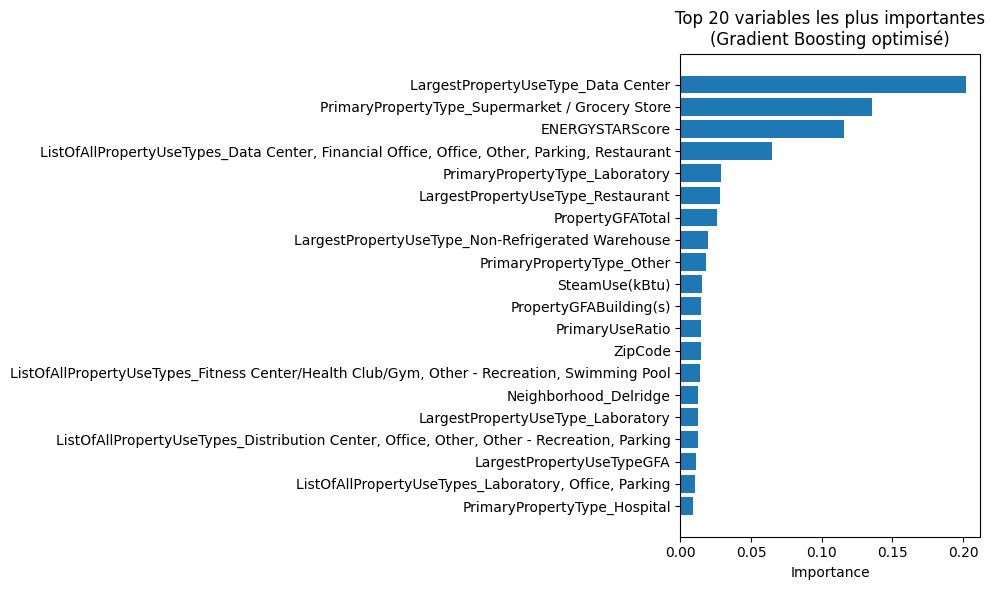

,feature,importance
382,LargestPropertyUseType_Data Center,0.201841
39,PrimaryPropertyType_Supermarket / Grocery Store,0.135689
13,ENERGYSTARScore,0.115454
94,"ListOfAllPropertyUseTypes_Data Center, Financi...",0.064622
26,PrimaryPropertyType_Laboratory,0.028351
422,LargestPropertyUseType_Restaurant,0.027616
7,PropertyGFATotal,0.025910
399,LargestPropertyUseType_Non-Refrigerated Warehouse,0.019338
31,PrimaryPropertyType_Other,0.018008
14,SteamUse(kBtu),0.015375


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Récupérer le meilleur pipeline depuis le GridSearch
best_model = grid_search.best_estimator_

# 2) Séparer préprocesseur et régleur
preprocessor = best_model.named_steps["preprocessor"]
regressor = best_model.named_steps["regressor"]

# 3) Noms des variables numériques (après transformation)
num_features = np.array(numeric_features)

# 4) Noms des variables catégorielles après OneHotEncoder
cat_encoder = preprocessor.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(categorical_features)

# 5) Concaténation des noms de features
feature_names = np.concatenate([num_features, cat_features])

# 6) Importances renvoyées par le GradientBoosting
importances = regressor.feature_importances_

feat_imp = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

# 7) Afficher les 20 variables les plus importantes
top_n = 20
feat_top = feat_imp.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(feat_top["feature"], feat_top["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title(f"Top {top_n} variables les plus importantes\n(Gradient Boosting optimisé)")
plt.tight_layout()
plt.show()

feat_top


### 5.6. Interprétation du modèle : importance des variables

L’analyse de la feature importance montre que le modèle Gradient Boosting s’appuie principalement sur des indicateurs liés **au type d’usage du bâtiment**. Cela est cohérent avec le domaine énergétique : certains usages, comme les data centers, les supermarchés ou les laboratoires, sont connus pour consommer beaucoup d’énergie en raison de leurs besoins techniques (serveurs, chaînes du froid, ventilation spécifique, etc.).

Voici les éléments les plus importants observés :

- **LargestPropertyUseType_Data Center** est de loin la variable la plus déterminante. Les data centers sont des bâtiments extrêmement énergivores, ce qui explique leur forte contribution dans les prédictions.
- **PrimaryPropertyType_Supermarket / Grocery Store** arrive également très haut. Les supermarchés possèdent beaucoup d’équipements électriques (réfrigération, éclairage, ventilation), ce qui augmente naturellement leur site EUI.
- **ENERGYSTARScore** occupe une place importante. Ce score étant un indicateur dérivé de la performance énergétique globale d’un bâtiment, il est logique qu’il aide fortement le modèle.
- Plusieurs déclinaisons de **LargestPropertyUseType** et **PrimaryPropertyType** ressortent également, confirmant que la **nature de l’activité** est un facteur explicatif majeur.
- Les variables liées aux surfaces, comme **PropertyGFATotal** et **LargestPropertyUseTypeGFA**, contribuent également aux prédictions : plus un bâtiment est grand, plus il consomme d’énergie.
- Certaines variables contextuelles comme **ZipCode** ou **Neighborhood_Delridge** apparaissent avec une importance plus faible mais non négligeable, indiquant qu’il existe possiblement des effets liés au quartier (climat local, densité urbaine, type de bâtiments).

De manière générale, le modèle semble apprendre correctement la relation entre les usages du bâtiment, leur taille, leur localisation, et leur niveau de consommation énergétique.  
L’importance relativement faible de certaines variables techniques montre que le comportement global du bâtiment est avant tout déterminé par **son type et sa surface**, ce qui correspond bien à l’intuition métier.


In [87]:
import bentoml


feature_names = X_train.columns.tolist()

# Sauvegarde du modèle BentoML
bentoml.sklearn.save_model(
    "seattle_energy_predictor",
    best_model,
    custom_objects={
        "feature_names": feature_names
    }
)

print("Modèle sauvegardé avec succès !")


Modèle sauvegardé avec succès !
